<a href="https://colab.research.google.com/github/FarizKesten/OverviewAutoencoders/blob/main/autoencoder_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using autoencoder to analyse 2-D dataset


### importing all the libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

import tensorflow as tf
tf.__version__

'2.12.0'

### load the dataset

In [4]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [5]:
# testing...
print(x_test[1,].shape)

(28, 28)


### define autoencoder model

In [6]:
# @title Dense Autoencoder

class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [7]:
# @title Convolutional Autoencoder

class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28,28,1)),                                           # N 1-28-28
        layers.Conv2D(16, (3, 3), strides=2, padding='same', activation='relu'), # N 64-14-14
        layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu'), # N 32-7-7
        # layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu'), # N 32-3-3
        # layers.Conv2D(64, (7,7)),                                              # N 64-1-1
    ], name= "encoder")

    self.decoder = tf.keras.Sequential([
        # layers.Conv2DTranspose(32, kernel_size=7, activation='relu'),                                              # N 32-7-7
        # layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu', output_padding=1),                                                # N 32-7-7
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu', output_padding=1),   # N 16-14-14
        layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid', output_padding=1), # N 1-28-28
    ], name="decoder")

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# autoencoder = Autoencoder(latent_dim, shape)
autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


### train the model

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))




Epoch 1/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0103 - val_loss: 0.0028
Epoch 2/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 3/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/10
1875/1875 [==============================] - 37s 20ms/step - loss: 9.7128e-04 - val_loss: 8.7577e-04
Epoch 5/10
1875/1875 [==============================] - 29s 16ms/step - loss: 7.5239e-04 - val_loss: 7.4794e-04
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 6.4436e-04 - val_loss: 6.1116e-04
Epoch 7/10
1875/1875 [==============================] - 28s 15ms/step - loss: 5.6737e-04 - val_loss: 5.1750e-04
Epoch 8/10
1875/1875 [==============================] - 26s 14ms/step - loss: 5.1442e-04 - val_loss: 4.9158e-04
Epoch 9/10
1875/1875 [==============================] - 35s 18ms/step - loss: 4.7328e-04 - val_loss: 4.3661e-04
Epoch 10/10
1875

In [9]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
Total params: 4,800
Trainable params: 4,800
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 16)       4624      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 1)        145       
 ranspose)                              


### predictions:




In [10]:
# @title reproduce input images
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

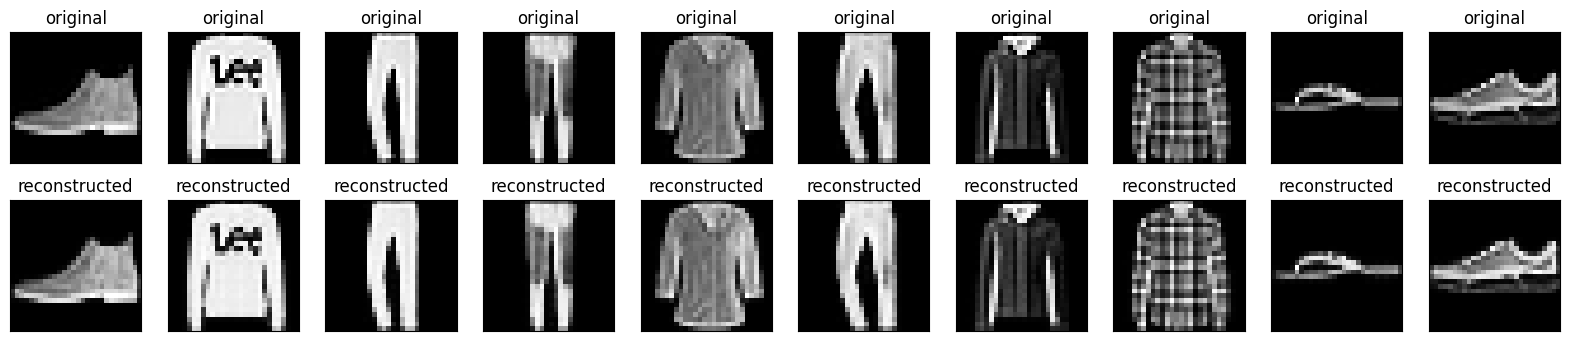

In [11]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
# @title Use as a denoiser


## Add rendom noice to the images
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

## clip top the range value of 0..1.0
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0, clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0, clip_value_max=1.)


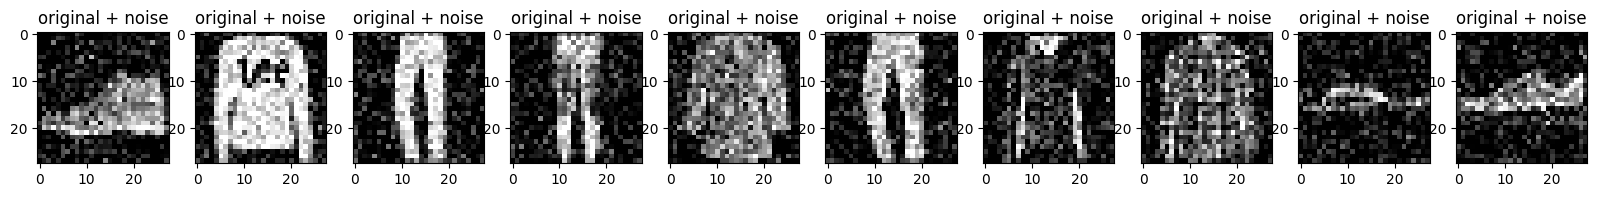

In [18]:
# plot the noisy images

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.title('original + noise')
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
plt.show()

In [24]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 2/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 3/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 4/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 8/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 9/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 10/10
1875/1875 [==============================] - 28s 15m

In [25]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

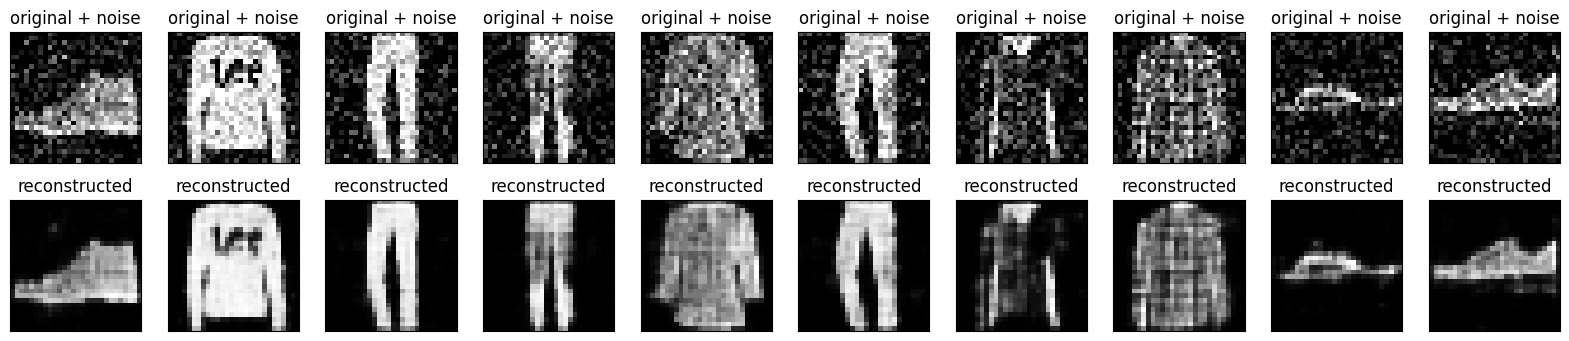

In [26]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+ 1 + n)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

